# **Task 2: Human Classification / Detection**

In [1]:
import os
import numpy as np
import zipfile
import struct
import cv2
import matplotlib.pyplot as plt
from skimage import feature
from skimage import exposure
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!mkdir Dataset

In [4]:
local_zip = '/content/gdrive/MyDrive/Colab Notebooks/CV_Assignment2/INRIA_Dataset_Samples.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Dataset/INRIA_Dataset_Samples')
zip_ref.close()

In [5]:
pos_image_test_dir = '/content/Dataset/INRIA_Dataset_Samples/Test/pos/'
neg_image_test_dir = '/content/Dataset/INRIA_Dataset_Samples/Test/neg/'

pos_image_train_dir = '/content/Dataset/INRIA_Dataset_Samples/Train/pos/'
neg_image_train_dir = '/content/Dataset/INRIA_Dataset_Samples/Train/neg/'

pos_images_test = os.listdir(pos_image_test_dir)
neg_images_test = os.listdir(neg_image_test_dir)

pos_images_train = os.listdir(pos_image_train_dir)
neg_images_train = os.listdir(neg_image_train_dir)

**Total Number of Images in Each Directory**

In [6]:
print('Total Positive Test Images:', len(os.listdir(pos_image_test_dir)))
print('Total Negative Test Images:', len(os.listdir(neg_image_test_dir)))
print('Total Positive Train Images:', len(os.listdir(pos_image_train_dir)))
print('Total Negative Train Images:', len(os.listdir(neg_image_train_dir)))

Total Positive Test Images: 1132
Total Negative Test Images: 453
Total Positive Train Images: 2416
Total Negative Train Images: 1218


**Checking Labels of Images**

In [7]:
print(pos_images_train[:10])

['person_170b.png', 'person_228a.png', 'crop001133a.png', 'crop001236d.png', 'person_and_bike_034b.png', 'crop001044b.png', 'crop001594b.png', 'person_091f.png', 'person_220a.png', 'person_and_bike_121a.png']


**Plotting Few Pictures**

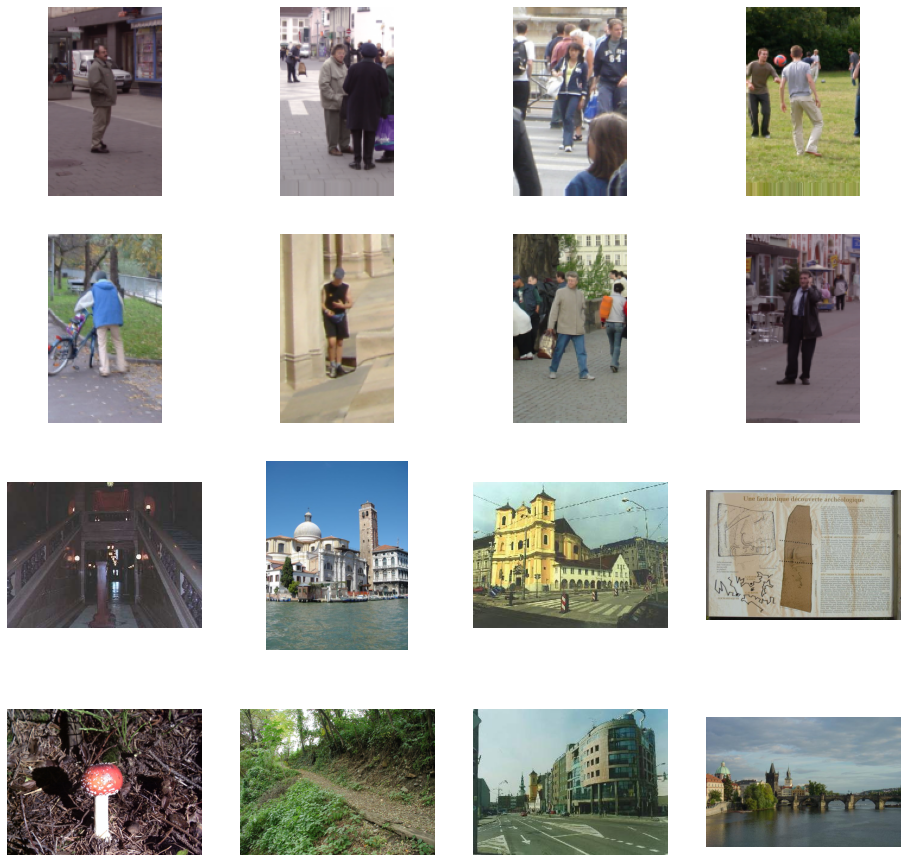

In [8]:
nrows = 4
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
pos_train_pics = [os.path.join(pos_image_train_dir, fname) 
                for fname in pos_images_train[pic_index-8:pic_index]]
neg_train_pics = [os.path.join(neg_image_train_dir, fname) 
                for fname in neg_images_train[pic_index-8:pic_index]]

for i, img_path in enumerate(pos_train_pics+neg_train_pics):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


**Computing HOG Features**



In [9]:
data = []
labels = []

def compute_HOG(image):
  Hog = feature.hog(image, orientations = 9, pixels_per_cell  = (8, 8), 
                    cells_per_block  = (2, 2), transform_sqrt=True, 
                    block_norm  = 'L2' , feature_vector=True)
  return Hog

for img in os.listdir(pos_image_train_dir):
  image= cv2.imread(os.path.join(pos_image_train_dir,img), 0 )
  image = cv2.resize(image, (128,64), interpolation = cv2.INTER_AREA)
  h_vector= compute_HOG(image)
  data.append(h_vector)
  labels.append(1) # 1 for positive images

for img in os.listdir(neg_image_train_dir):
  image= cv2.imread(os.path.join(neg_image_train_dir,img), 0 )
  image = cv2.resize(image, (128,64), interpolation = cv2.INTER_AREA)
  h_vector= compute_HOG(image)
  data.append(h_vector)
  labels.append(0) # 0 for negative images


# **SVM & RF**

**Training the Model**

In [10]:
modelSVC = LinearSVC()
modelSVC.fit(data, labels)
print("SVC Training Completed.")
joblib.dump(modelSVC, 'classification_detection_SVM.pkl') #saving trained svc model

modelRF = RandomForestClassifier()
modelRF.fit(data, labels)
print("RF Training Completed.")
joblib.dump(modelRF, 'classification_detection_RF.pkl') # saving trained rf model

SVC Training Completed.
RF Training Completed.


['classification_detection_RF.pkl']

**Testing the Model**

In [11]:
test_data_pos = []
test_labels_pos = []
test_data_neg = []
test_labels_neg = []

for img in os.listdir(pos_image_test_dir):
  image1= cv2.imread(os.path.join(pos_image_test_dir,img), 0 )
  image1 = cv2.resize(image1, (128,64), interpolation = cv2.INTER_AREA)
  h_vector= compute_HOG(image1)
  test_data_pos.append(h_vector)
  test_labels_pos.append(1)

for img in os.listdir(neg_image_test_dir):
  image1= cv2.imread(os.path.join(neg_image_test_dir,img), 0 )
  image1 = cv2.resize(image1, (128,64), interpolation = cv2.INTER_AREA)
  h_vector= compute_HOG(image1)
  test_data_neg.append(h_vector)
  test_labels_neg.append(0)

**Predictions**

In [12]:
modelSVC = joblib.load('classification_detection_SVM.pkl')
pos_predictions_svm = modelSVC.predict(test_data_pos)
neg_predictions_svm = modelSVC.predict(test_data_neg)
print("SVM Predictions Complete!")

modelRF = joblib.load('classification_detection_RF.pkl')
pos_predictions_rf = modelRF.predict(test_data_pos)
neg_predictions_rf = modelRF.predict(test_data_neg)
print("RF Predictions Complete!")

SVM Predictions Complete!
RF Predictions Complete!


# **Quantitative Results**

**Performance Measures SVM**

In [13]:
### True Positives, False Positives & True Negatives, False Negatives
true_positives = cv2.countNonZero(pos_predictions_svm)
false_negatives = pos_predictions_svm.shape[0] - true_positives

false_positives = cv2.countNonZero(neg_predictions_svm)
true_negatives = neg_predictions_svm.shape[0] - false_positives

print ("True Positives: " + str(true_positives), "False Positives: " + str(false_positives))
print ("True Negatives: " + str(true_negatives), "False Negatives: " + str(false_negatives))

### Precision & Recall
precision = float(true_positives) / (true_positives + false_positives)
recall = float(true_positives) / (true_positives + false_negatives)

### Accuracy
accuracy = float(true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)

### F Measure
f1 = 2*precision*recall / (precision + recall)

print ("Precision: " + str(precision))
print("Recall: " + str(recall))
print("Accuracy: " + str(accuracy))
print ("F1 Score: " + str(f1))

True Positives: 1075 False Positives: 20
True Negatives: 433 False Negatives: 57
Precision: 0.9817351598173516
Recall: 0.9496466431095406
Accuracy: 0.9514195583596214
F1 Score: 0.9654243376740009


**Performance Measures RF**

In [14]:
### True Positives, False Positives & True Negatives, False Negatives
true_positives = cv2.countNonZero(pos_predictions_rf)
false_negatives = pos_predictions_rf.shape[0] - true_positives

false_positives = cv2.countNonZero(neg_predictions_rf)
true_negatives = neg_predictions_rf.shape[0] - false_positives

print ("True Positives: " + str(true_positives), "False Positives: " + str(false_positives))
print ("True Negatives: " + str(true_negatives), "False Negatives: " + str(false_negatives))

### Precision & Recall
precision = float(true_positives) / (true_positives + false_positives)
recall = float(true_positives) / (true_positives + false_negatives)

### Accuracy
accuracy = float(true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)

### F Measure
f1 = 2*precision*recall / (precision + recall)

print ("Precision: " + str(precision))
print("Recall: " + str(recall))
print("Accuracy: " + str(accuracy))
print ("F1 Score: " + str(f1))

True Positives: 1112 False Positives: 52
True Negatives: 401 False Negatives: 20
Precision: 0.9553264604810997
Recall: 0.9823321554770318
Accuracy: 0.9545741324921135
F1 Score: 0.9686411149825784


# **Qualitative Results**

**SVM**

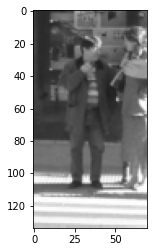

Predicted Label SVM = 1
Actual Label SVM =  1


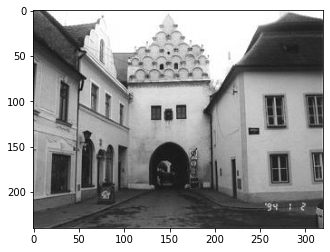

Predicted Label SVM = 0
Actual Label SVM =  0


In [16]:
img_neg = []
img_pos = []
pos_index = 14
neg_index = 18

pos_path = '/content/Dataset/INRIA_Dataset_Samples/Test/pos/'+pos_images_test[pos_index]
neg_path = '/content/Dataset/INRIA_Dataset_Samples/Test/neg/'+neg_images_test[neg_index]

image_pos = cv2.imread(pos_path,0)
image_neg = cv2.imread(neg_path,0)

plt.imshow(cv2.cvtColor(image_pos,cv2.COLOR_BGR2RGB))
plt.show()
image_p = cv2.resize(image_pos, (128,64), interpolation = cv2.INTER_AREA)
h_vector_p= compute_HOG(image_p)
img_pos.append(h_vector_p)
label_pos = modelSVC.predict(img_pos)
print("Predicted Label SVM =", label_pos[0])
print("Actual Label SVM = ", test_labels_pos[pos_index])

plt.imshow(cv2.cvtColor(image_neg,cv2.COLOR_BGR2RGB))
plt.show()
image_n = cv2.resize(image_neg, (128,64), interpolation = cv2.INTER_AREA)
h_vector_n= compute_HOG(image_n)
img_neg.append(h_vector_n)
label_neg = modelSVC.predict(img_neg)
print("Predicted Label SVM =", label_neg[0])
print("Actual Label SVM = ", test_labels_neg[neg_index])

**RF**

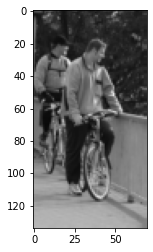

Predicted Label RF = 1
Actual Label RF =  1


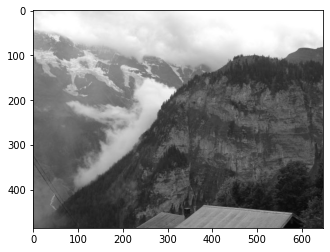

Predicted Label RF = 0
Actual Label RF =  0


In [17]:
img_neg = []
img_pos = []
pos_index = 5
neg_index = 10

pos_path = '/content/Dataset/INRIA_Dataset_Samples/Test/pos/'+pos_images_test[pos_index]
neg_path = '/content/Dataset/INRIA_Dataset_Samples/Test/neg/'+neg_images_test[neg_index]

image_pos = cv2.imread(pos_path,0)
image_neg = cv2.imread(neg_path,0)

plt.imshow(cv2.cvtColor(image_pos,cv2.COLOR_BGR2RGB))
plt.show()
image_p = cv2.resize(image_pos, (128,64), interpolation = cv2.INTER_AREA)
h_vector_p= compute_HOG(image_p)
img_pos.append(h_vector_p)
label_pos = modelRF.predict(img_pos)
print("Predicted Label RF =", label_pos[0])
print("Actual Label RF = ", test_labels_pos[pos_index])

plt.imshow(cv2.cvtColor(image_neg,cv2.COLOR_BGR2RGB))
plt.show()
image_n = cv2.resize(image_neg, (128,64), interpolation = cv2.INTER_AREA)
h_vector_n= compute_HOG(image_n)
img_neg.append(h_vector_n)
label_neg = modelRF.predict(img_neg)
print("Predicted Label RF =", label_neg[0])
print("Actual Label RF = ", test_labels_neg[neg_index])